In [1]:
%env NEPTUNE_API_TOKEN='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2MTRjNjcyYi0yYzNhLTQwN2UtYTliOS05MzVhN2FmZTBiNGUifQ=='

env: NEPTUNE_API_TOKEN='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2MTRjNjcyYi0yYzNhLTQwN2UtYTliOS05MzVhN2FmZTBiNGUifQ=='


In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=15)
import neptune.new as neptune


In [3]:
MAX_ABS_VEL = 0.1
VEL_LINSPACE = np.linspace(-MAX_ABS_VEL, MAX_ABS_VEL, 100)


In [4]:
def load_ac(run, epoch: int):
    tmp_model_dest = '/tmp/model.pt'
    run[f'model/model{epoch}.pt'].download(destination=tmp_model_dest)
    ac = torch.load(tmp_model_dest)
    os.unlink(tmp_model_dest)
    return ac

def pi_actions(obs, ac):
    ret = np.empty((100, 100))
    for i, velocity in enumerate(VEL_LINSPACE):
        obs[:, 4] = velocity
        ret[:, i] = ac.pi.forward(obs).detach().numpy()[:, 0]
    return (ret + 1) / 2

def on_policy_v(obs, ac):
    q_vals = np.empty((100, 100))
    for i, velocity in enumerate(VEL_LINSPACE):
        obs[:, 4] = velocity
        q = ac.q if hasattr(ac, 'q') else ac.q1
        q_vals[:, i] = q.forward(obs, ac.pi.forward(obs)).detach().numpy()
    return q_vals

def imshow(arr, max_height):
    plt.imshow(
    arr,
    origin='lower',
    extent=(-MAX_ABS_VEL, MAX_ABS_VEL, 0, 1.5 * max_height),
    aspect='auto',
    )
    plt.colorbar()
    plt.xlabel("velocity")
    plt.ylabel("position")


In [5]:
def plot_v_pi(alg: str, run_nr: int):
    run = neptune.init(f'kajetan.janiak/hover1d-{alg}', run=f"H1{alg.upper()}-{run_nr}")
    radius = run['env/params/planet_radius'].fetch()
    max_height = run['env/params/reward_max_height'].fetch()
    pos_linspace = torch.linspace(radius, radius + 1.5 * max_height, 100)
    obs = torch.zeros((100, 6))
    obs[:, 1] = pos_linspace
    obs[:, 2] = 1.5 * np.pi
    for epoch in range(5, 101, 5):
        ac = load_ac(run, epoch)
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.title("value function")
        imshow(on_policy_v(obs, ac), max_height)
        plt.subplot(122)
        plt.title("policy")
        imshow(pi_actions(obs, ac), max_height)
        plt.suptitle(f"epoch {epoch}")
        plt.tight_layout()

https://app.neptune.ai/kajetan.janiak/hover1d-td3/e/H1TD3-68


MissingFieldException: 
[95m
----MissingFieldException-------------------------------------------------------
[0m
Field "model/model100.pt" not found.

There are two possible reasons:
* There is a typo in a path. Double-check your code for typos.
* You are fetching a field that other process created, but local representation is not synchronized.

If you are sending metadata from multiple processes at the same time, synchronize the local representation before fetching values:
	[96mrun.sync()[0m

[92mNeed help?[0m-> https://docs.neptune.ai/getting-started/getting-help


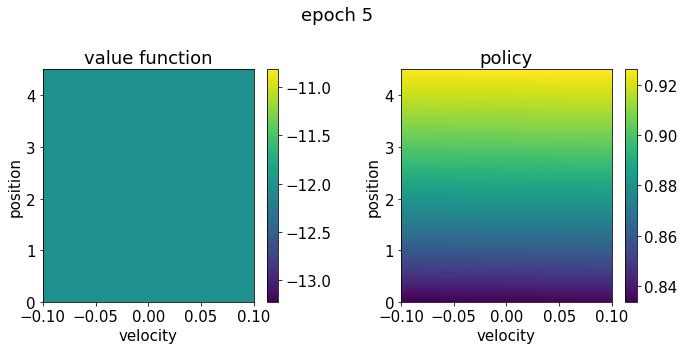

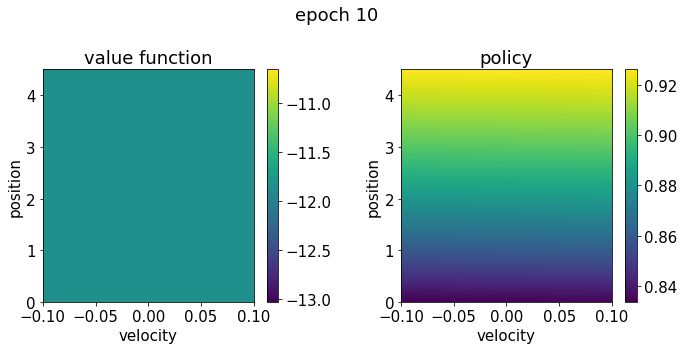

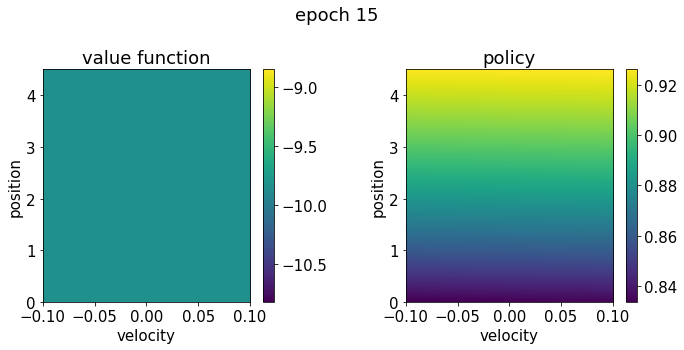

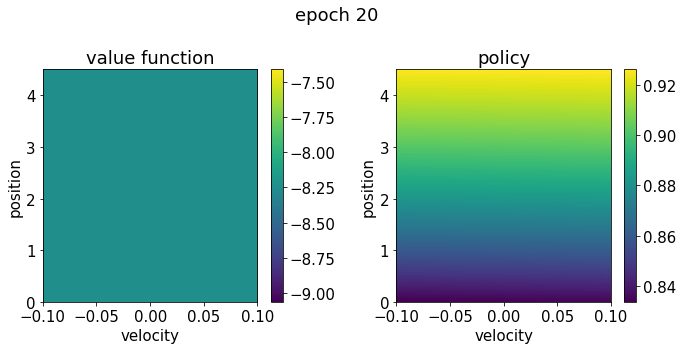

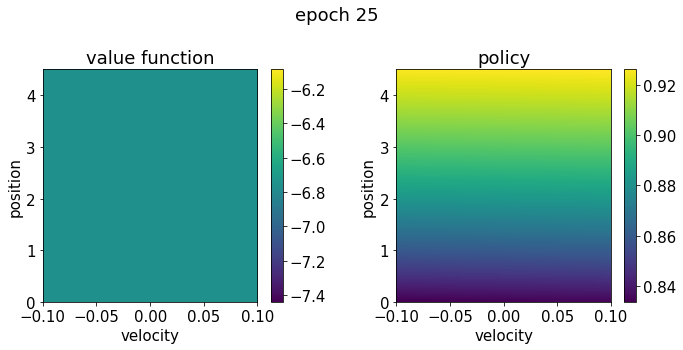

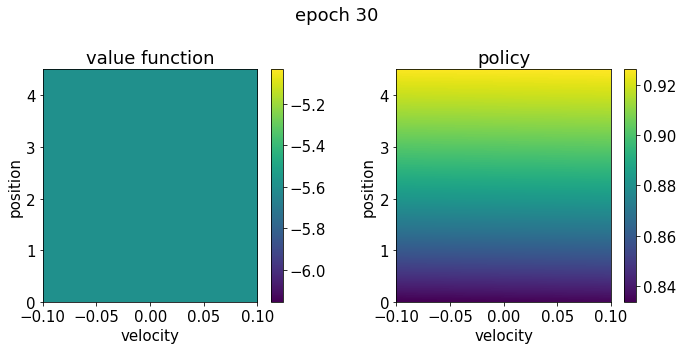

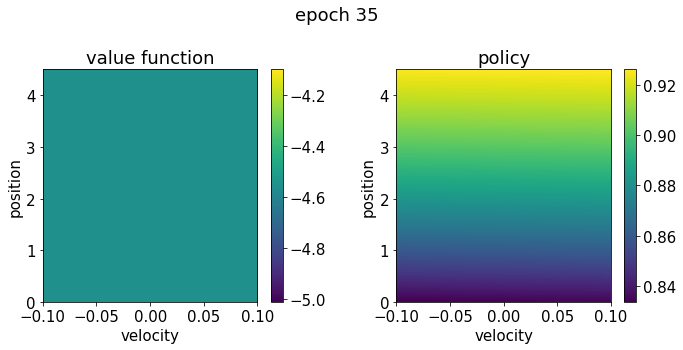

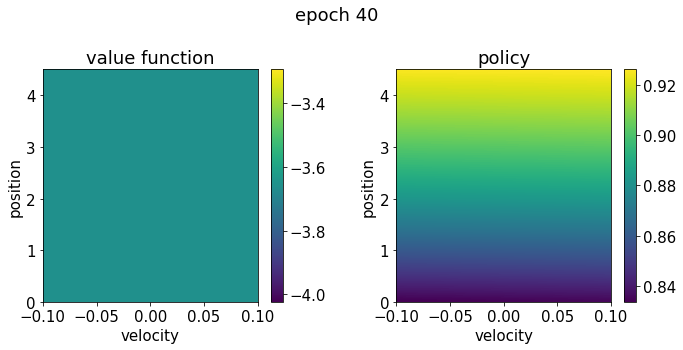

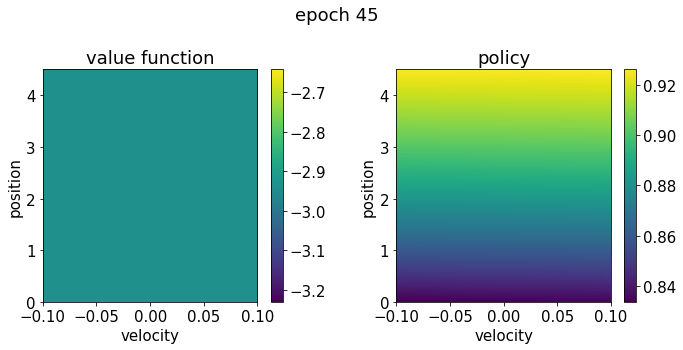

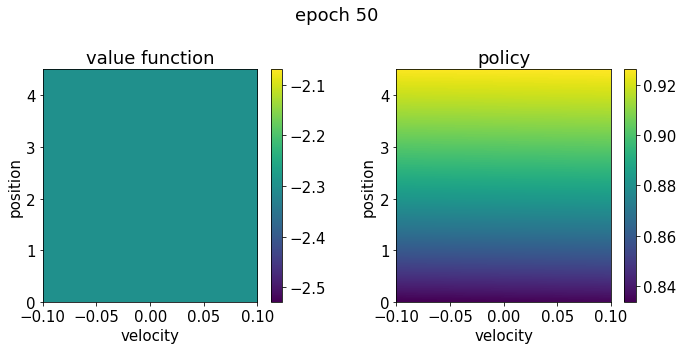

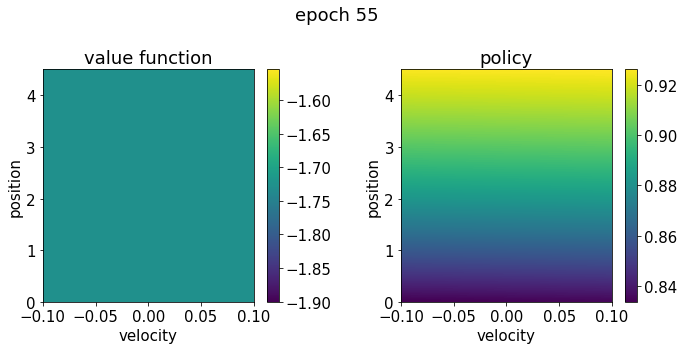

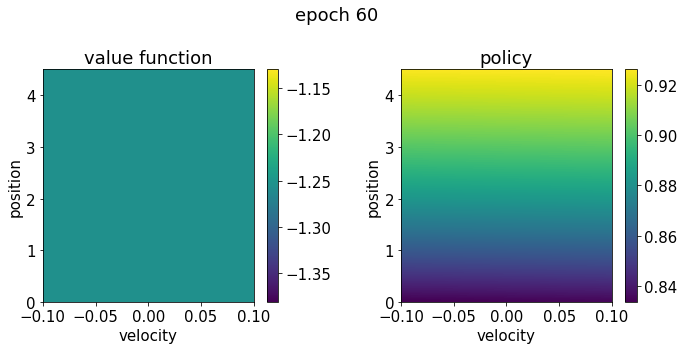

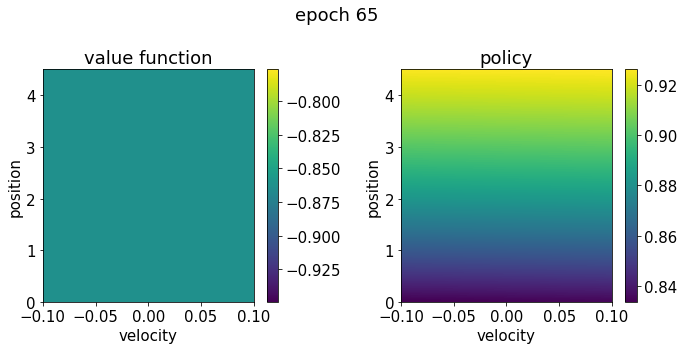

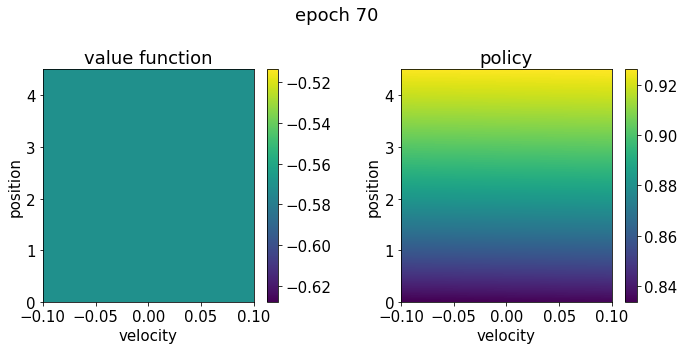

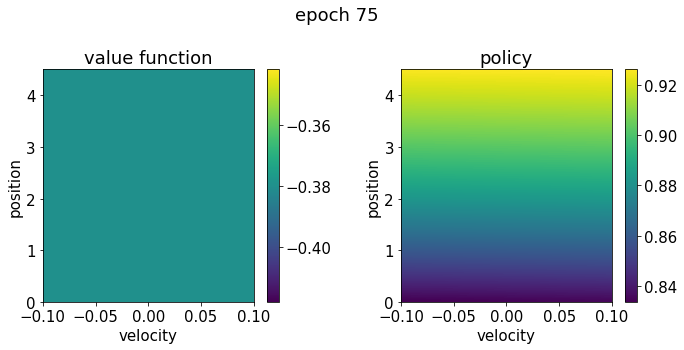

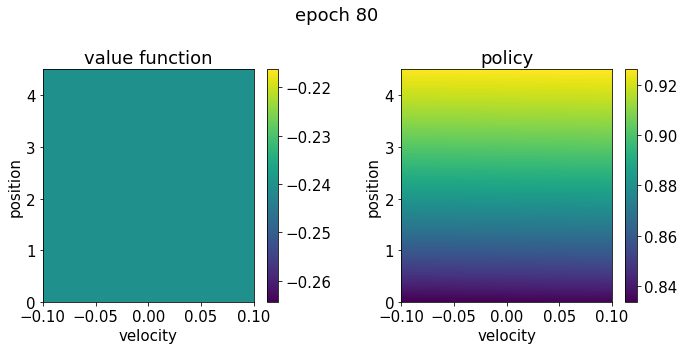

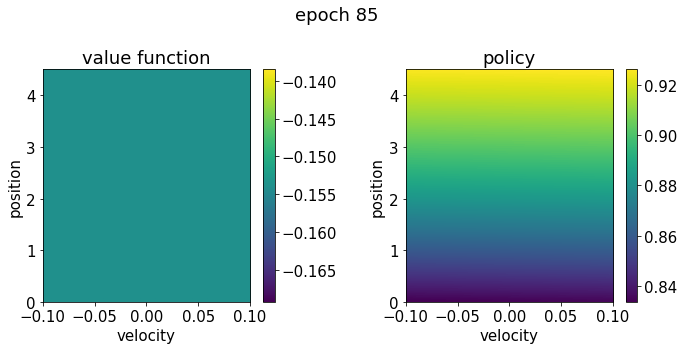

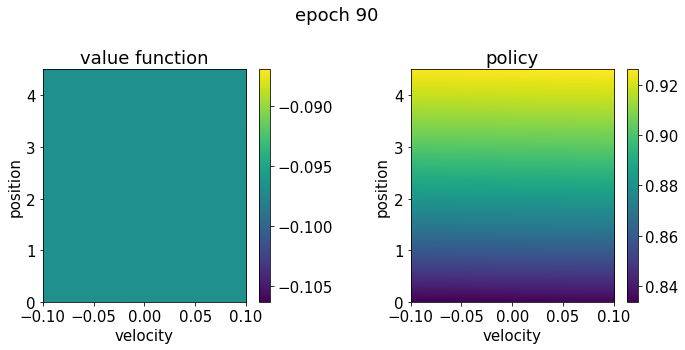

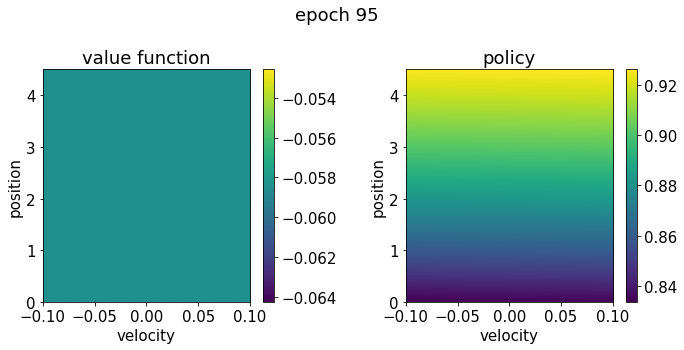

In [8]:
plot_v_pi('td3', 68)
